***
Pre-processing code for data analysis of CBGB source. Functions intended to be imported into a Jupyter notebook. 

Written by Emily Pan (emilypan@caltech.edu). 
***

Define input values as follows:  
    &emsp;`folder_path`: local path of the folder containing raw data samples.   
    &emsp;`file_name`: name of a scan's file family.   
        &emsp;&emsp;i.e. scan 1 is of the form `file_name = 'scan_1_'`  
    &emsp;`file_num`: optional parameter to refer to a single file in a scan.   
        &emsp;&emsp;i.e. file 1 in scan 1 is of the form `file_num = str(1)`  
    &emsp;`channels`: array whos indices correspond to each channel of data.  
        &emsp;&emsp;Fill array with each channel's corresponding tag `'abs'` for absorption data, `'fluor'` for flouresence data.  
        
A single file should be of the form `folder_path` + `file_name` + `file_num`.txt

In [22]:
# code_path = r'C:\Users\User\Dropbox (Hutzler Lab)\HutzlerLabShared\Personal\EmilyPan\activework\'
folder_path = 'C:/Users/User/Dropbox (Hutzler Lab)/HutzlerLabShared/Personal/EmilyPan/activework/Data Samples/20210520'

# file_num = str(1)
file_name = 'scan_1_'

channels = ['abs', 'abs', 'abs', 'fluor', 'abs']

In [10]:
%matplotlib inline
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
import sys
import pickle
import os

from scipy.signal import butter, sosfiltfilt
from scipy.optimize import curve_fit

C:/Users/User/Dropbox (Hutzler Lab)/HutzlerLabShared/Personal/EmilyPan/activework/Data Samples/20210520/scan_1_1.txt
[-2.   -1.99 -1.98 ... 12.97 12.98 12.99]
(5,)
<class '__main__.TimeSeries'>
[0.00301285 0.0029667  0.00292042 ... 0.00080792 0.00080932 0.0008103 ]


<ipython-input-101-a7081ab4966e>:51: RuntimeWarning: invalid value encountered in log
  processed = np.log(offset/flat)


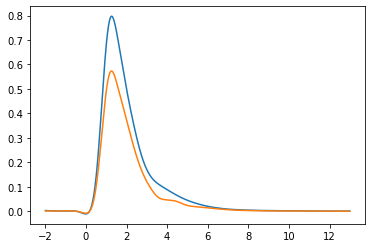

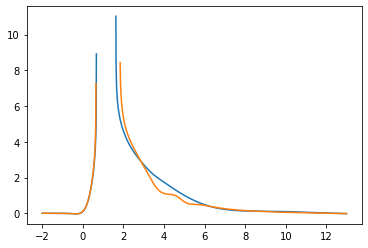

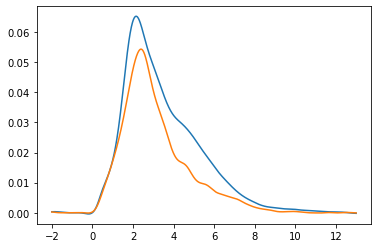

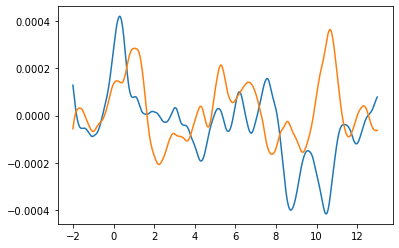

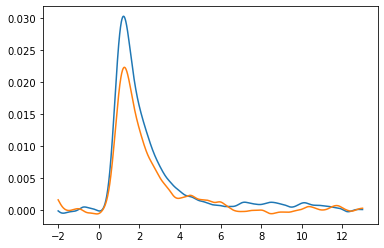

In [141]:
file_path = get_data_filepath(folder_path, file_name, file_num)
print(file_path)
ex_data = read_single_data_file(file_path, channels)
print(ex_data.data[0].generate_time_array())
print(ex_data.data.shape)


# print(ex_ts)
# plot_TimeSeries(ex_ts)
# print(ex_data.data)
# plot_FileData(ex_data)
scandata = get_scan(folder_path, file_name, 1, 2, channels)
print(type(scandata.data[0][0]))
print(scandata.data[0][0].data)
plot_ScanData(scandata)

In [113]:
class TimeSeries:
    """
    A class to represent a single channel's time series data.
    
    Attributes
    ----------
    data : array 
            Data values of the time series. 
    meta : dict 
            Metadata of the time series.
    channel : int
            Index of the given array 'channels' the data was sourced from. Access the type of data (abs/fluor) with channels[channel]. 
    
    Methods
    -------
    generate_time_array():
        Generates corresponding time array (in ms) for the data using metadata stats. Adjusted so that t=0 occurs when trigger fires.
    """
    
    def __init__(self, ts_data, ts_meta, channel):
        """
        Constructs all necesssary attributes for the TimeSeries object.
        
        Parameters
        ----------
        ts_data : array
               Data values (floats) of the time series. 
        ts_meta : dict 
               Metadata of the time series.
        channel : int
                Index of the given array 'channels' the data was sourced from. Access the type of data (abs/fluor) with channels[channel]. 
        """
        
        self.channel = channel
        self.meta = ts_meta
        self.data = ts_data
    
    def generate_time_array(self):
        """
        Generates corresponding time array (in ms) for the data using metadata stats. Adjusted so that t=0 occurs when trigger fires.
        
        Returns
        -------
        time_ms : array
                Array of time indices (in ms).
        """
        
        t0 = self.meta['start']
        dt = self.meta['dt']
        npnts = len(self.data)
        time_ms = np.round(np.linspace(t0,dt*(npnts-1)+t0,npnts),decimals = 6)
        time_ms-=self.meta['YAGtrig']
        return time_ms

class FileData:
    """
    A class to represent data extracted from a single file.
    
    Attributes
    ----------
    data : array 
            Data values of the file. The indices of the array correspoond to the channels. Each channel is a TimeSeries object.
    meta : dict 
            Metadata of the file.
    """
    
    def __init__(self, file_data, file_meta):
        """
        Constructs all necesssary attributes for the FileData object.
        
        Parameters
        ----------
        ts_data : array
            Data values of the file. The indices of the array correspoond to the channels. Each channel is a TimeSeries object.
        ts_meta : dict 
               Metadata of the file.
        """
        
        self.data = file_data
        self.meta = file_meta
    

class ScanData:
    """
    A class to represent data extracted from a single file.
    
    Attributes
    ----------
    data : array 
            Data values of the file. The indices of the array correspoond to the channels. Each channel is a TimeSeries object.
    meta : dict 
            Metadata of the file.
    """
    
    def __init__(self, scan_data, scan_meta):
        self.data = scan_data
        self.meta = scan_meta
         

In [70]:
def read_single_data_file(file_path, process_data=True):
    '''
    Extracts raw and metadata from a file given its path, stores data as a FileData object.
    
    Parameters
    ----------
    file_path : str
        Full local path to data file. Generated from get_data_filepath. 
    process_data: bool
        True to apply preprocessing functions to raw data, False otherwise.
        
    Returns
    -------
    filedata : FileData
        FileData object to hold contents of the file.
    '''
    
    header_lines = header_size(file_path)
    data_start = lines_before_data(file_path)
    meta = import_metadata(file_path)
    raw = import_raw(file_path)
    
    file_data_arr = np.ndarray(shape=[len(channels)], dtype=TimeSeries)
    
    for i in range(len(channels)):
        channel_ts = TimeSeries(raw[i], meta, i)
        if process_data == True:
            processed = process(channel_ts)
            file_data_arr[i] = processed
        else:
            file_data_arr[i] = channel_ts
    filedata = FileData(file_data_arr, meta)
    return filedata

def get_data_filepath(folder_path, file_name, file_num):
    '''
    Generates the full file path for given file of the form "name_num.txt" located in the folder given by
    folder_path (an absolute path). 
    '''
    file = file_name + file_num + '.txt'
    full_path = folder_path + "/" + file
    return full_path

def header_size(file_path, lim=1000):
    '''
    Returns the number of lines in the header, where the end of the header is marked by
    "***end of header***" in file. 
    '''
    return count_lines(file_path, "***end of header***")

def lines_before_data(file_path):
    '''
    Returns the number of lines until data array begins. 
    '''
    return count_lines(file_path, "time")

def count_lines(file_path, delim, lim=1000):
    '''
    Returns the number of lines before the delimiter phrase in file. 
    '''
    with open(file_path, 'r') as f:
        end = False
        lines = 0;
        while end == False:
            curr_line = f.readline().strip('\n')
            if lines > lim:
                print("Could not find {} in {} lines of {}".format(delim, lines, file_path))
                break
            elif (delim in curr_line):
                end = True
            lines += 1
    return lines

def split_strip(string):
    return string.split(':')[-1].strip(';')

def import_metadata(file_path):
    """
    Imports metadata from a file as a dictionary. 
    """
    metadata_lines = lines_before_data(file_path)
    Time_Read = 0
    
    # Store metadata lines in array
    lines = []
    with open(file_path, 'r') as f:
        for i in range(metadata_lines):
            lines.append(f.readline().strip('\n'))
    
    # Fill metadata dictionary
    meta = {}
    for text in lines:
        if 'run number' in text:
            meta['run'] = int(split_strip(text))
        if 'command file' in text:
            meta['command file'] = split_strip(text).split('\\')[-1].strip('.txt')
        if 'comment' in text:
            meta['comment'] = text.split(':')[1]
        if 'wavemeter(cm-1)' in text:
            meta['frequency'] = float(split_strip(text))
        if 'offset' in text:
            meta['cavity_offset'] = float(split_strip(text))
        if 't0' in text:
            H_M_S = text.strip('t0').strip().split('\t')[0].split(' ')[-1].split(':')
            hours_in_sec = float(H_M_S[0])*60*60
            min_in_sec = float(H_M_S[1])*60
            sec = float(H_M_S[2])
            meta['trigtime'] = hours_in_sec+min_in_sec+sec
        if 'delta t' in text:
            meta['dt'] = [float(x) for x in text.strip('delta t\t').split('\t')][0]*1000 #convert seconds to ms
        if 'HFwavemeter' in text:
            meta['frequency_HF']  = float(split_strip(text))
    meta['start'] = 0
    meta['channels'] = channels
    meta['YAGtrig'] = 2 #hard coded for now
    return meta

def import_raw(file_path):
    """
    Imports raw data as an array.
    """
    try:
        arr = np.genfromtxt(file_path,delimiter='', skip_header = lines_before_data(file_path))
        raw_data = np.array([ch for ch in arr.T[1:]])
    except ValueError:
        print('Issues with file located at: ',file_path)
        raw_data = np.array([np.zeros(10000),np.zeros(10000)])
    except OSError:
        print('Issues with file located at: ',file_path)
        raw_data = np.array([np.zeros(10000),np.zeros(10000)])
    return raw_data


In [138]:
def get_scan(folder_path, file_name, start, end):
    """
    Gets data from a scan of data, stores as a ScanData object.
    
    Parameters
    ----------
    folder_path : str
        Local path folder where all files from scan are stored.
    file_name : str
        Identifies the specific scan. All files in scan should have the same file_name prefix.
    start : int
        First file in scan.
    end : int
        Last file in scan.
    
    Returns
    -------
    scan : ScanData
        ScanData object to hold the contents of the scan.
    """
    
    scan_files = get_scan_files(folder_path, file_name, start, end)
    scan_data = np.ndarray(shape=[len(channels), len(scan_files)], dtype=TimeSeries)
    scan_meta = []
    
    for i in range(len(scan_files)):
        filedata = read_single_data_file(scan_files[i])
        scan_meta.append(filedata.meta)
        for j  in range(len(channels)):
            scan_data[j][i] = filedata.data[j]

    scan = ScanData(scan_data, calculate_meta(scan_meta))
    return scan
    
def get_scan_files(folder_path, file_name, start, end):
    """
    Returns a list of file paths to the files in the scan.
    """
    scan_files = []
    for file_num in range(start, end+1):
        file = get_data_filepath(folder_path, file_name, str(file_num))
        scan_files.append(file)
    return scan_files

def calculate_meta(meta):
    """
    Calculates metadata for the scan by averaging values.
    """
    #TODO
    return meta[0]

In [6]:
def write_data_ts(file_path, data_ts):
    """
    Writes a TimeSeries object to a specified file path. If file already exists, delete file and overwrite.
    """
    if os.path.isfile(file_path):
        delete_file(file_path)
    with open(file_path, 'wb') as pickle_file:
        pickle.dump(data_ts, pickle_file)
            
def read_file_ts(file_path):
    """
    Reads a file containing a Timeseries object. 
    """
    with open(file_path, 'rb') as pickle_file:
        data_ts = pickle.load(pickle_file)
    return data_ts

def delete_file(file_path):
    """
    Deletes file located at file_path.
    """
    os.remove(file_path)

In [139]:
def plot_TimeSeries(timeseries):
    plt.figure()
    plt.plot(timeseries.generate_time_array(),timeseries.data)
    
def plot_FileData(filedata):
    for ts in filedata.data:
        plt.figure()
        plot_TimeSeries(ts)

def plot_ScanData(scandata):
    ts_sample = scandata.data[0][0]
    time = ts_sample.generate_time_array()
    for channel in range(len(channels)):
        plt.figure()
        for ts in scandata.data[channel]:
            plt.plot(time, ts.data)

In [101]:
def process(timeseries):
    """
    Applies Butterworth filter and handles offset. 
    """
    filt_ts = apply_filter(timeseries)
    processed_ts = remove_drift_offset(filt_ts, channels[timeseries.channel])
        
    return processed_ts

def apply_filter(timeseries, order=2, lim=900):
    time_array = timeseries.generate_time_array()
    N = len(time_array)
    ds = (time_array[1] - time_array[0]) / 1000
    fs = np.round(1/ds, 4)
    newdata = butter_lowpass_filter(np.array(timeseries.data), lim, fs, order)
    filt_ts = TimeSeries(np.array(newdata), timeseries.meta, timeseries.channel)
    return filt_ts
    
    
def butter_lowpass(lim, fs, order=2):
    # Nyquist frequency = 1/2 of sampling rate
    nyq = 0.5 * fs
    lim = lim / nyq
    sos = butter(order, lim, analog=False, btype='lowpass', output='sos')
    return sos

def butter_lowpass_filter(data, lim, fs, order):
    sos = butter_lowpass(lim, fs, order=order)
    filtered = sosfiltfilt(sos, data)
    return filtered

def remove_drift_offset(timeseries, tag):
    time_array = np.array(timeseries.generate_time_array())
    data = np.array(timeseries.data)
    trigger_index = np.searchsorted(time_array, 0)
    pre_index = np.searchsorted(time_array, -0.1)
    post_index = np.searchsorted(time_array, (time_array[-1] - 1))
    
    fit_area = np.concatenate((time_array[:pre_index], time_array[post_index:]))
    fit_data = np.concatenate((data[:pre_index], data[post_index:]))
    
    popt, _ = curve_fit(linear_fit_func, fit_area, fit_data, p0 = [((fit_data[-1]-fit_data[0]) / (time_array[-1] - time_array[0])), fit_data.mean()])
    m = popt[0]
    b = popt[1]
#     plt.plot(fit_area, linear_fit_func(fit_area, *popt))

    if tag=='fluor':
        flat = data - linear_fit_func(time_array, m, b)
        offset = flat[:trigger_index].mean()
        processed = flat - offset
    elif tag=='abs':
        flat = data - linear_fit_func(time_array, m, b) + data[pre_index]
        offset = flat[:trigger_index].mean()
        processed = np.log(offset/flat)
    else:
        return 'failed'
    
    processed_ts = TimeSeries(np.array(processed), timeseries.meta, timeseries.channel)

    return processed_ts
        
def linear_fit_func(x, m, b):
    return m*x + b
    